In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
print(os.getcwd())

2024-02-16 04:32:27.121736: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 04:32:27.209561: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 04:32:27.211565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 04:32:30.851237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/eoafrica/shared/Updated_dataset_Codes/Models


In [2]:
# Read the shapefile
df=gpd.read_file("points_data.shp") #("/content/drive/MyDrive/RF_model_Flood_susceptibility/Merged_RF.shp")
df.head()

,id,label,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text,geometry
0,0,0,810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7,POINT (648355.689 1032128.503)
1,1,0,798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7,POINT (652338.758 1039898.468)
2,2,0,783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7,POINT (654594.349 1045368.461)
3,3,0,845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7,POINT (653891.492 1031276.320)
4,4,0,803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7,POINT (657859.303 1042542.024)


In [3]:
df= df.drop(labels = ["id","Soil_Test"], axis=1)

In [4]:
print(df.describe().T)  #Values are already normalized in GIS before fitting. 

           count          mean           std           min         25%  \
label      393.0  6.921120e-01  4.622084e-01  0.000000e+00    0.000000   
DEM        393.0  7.298244e+02  4.759590e+01  6.960000e+02  706.000000   
Slope      393.0  4.342038e+00  5.112538e+00  0.000000e+00    1.811248   
Aspect     393.0 -7.185369e+02  2.907206e+03 -9.999000e+03   71.565048   
Curvature  393.0  7.002544e-02  8.639245e-01 -2.560000e+00   -0.640000   
CN         393.0  6.035623e+01  1.044618e+01  3.000000e+01   58.000000   
TWI        393.0 -1.731717e+20  2.424395e+21 -3.402823e+22    6.958297   
Rainfall   393.0  1.191060e+01  2.368298e+00  6.662645e+00   10.237988   
LULC       393.0  4.208651e+01  2.634587e+01  2.000000e+01   20.000000   
Soil_Text  393.0  4.175573e+00  1.418613e+00  1.000000e+00    4.000000   

                  50%         75%          max  
label        1.000000    1.000000     1.000000  
DEM        715.000000  728.000000  1042.000000  
Slope        2.918995    4.573921    3

In [5]:
## Check if there is null values
print(df.isnull().sum())
#df = df.dropna()

label        0
DEM          0
Slope        0
Aspect       0
Curvature    0
CN           0
TWI          0
Rainfall     0
LULC         0
Soil_Text    0
geometry     0
dtype: int64


In [6]:
df = df.rename(columns={'label':'class'})
print(df.dtypes)

class           int64
DEM             int64
Slope         float64
Aspect        float64
Curvature     float64
CN              int64
TWI           float64
Rainfall      float64
LULC            int64
Soil_Text       int64
geometry     geometry
dtype: object


In [7]:
#df = merged.rename(columns={'FSM':'Label'})
print(df.dtypes)

class           int64
DEM             int64
Slope         float64
Aspect        float64
Curvature     float64
CN              int64
TWI           float64
Rainfall      float64
LULC            int64
Soil_Text       int64
geometry     geometry
dtype: object


<Axes: xlabel='class', ylabel='count'>

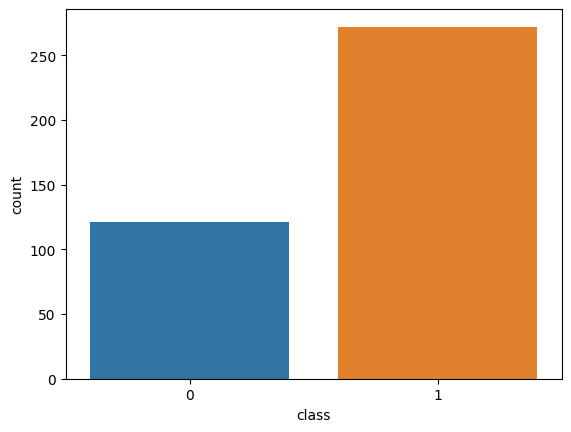

In [8]:
#Understand the data 
# The dataset includes the same number of flooded and not flooded locations
sns.countplot(x="class", data=df) #0 - Notflooded   1 - Flooded

<Axes: >

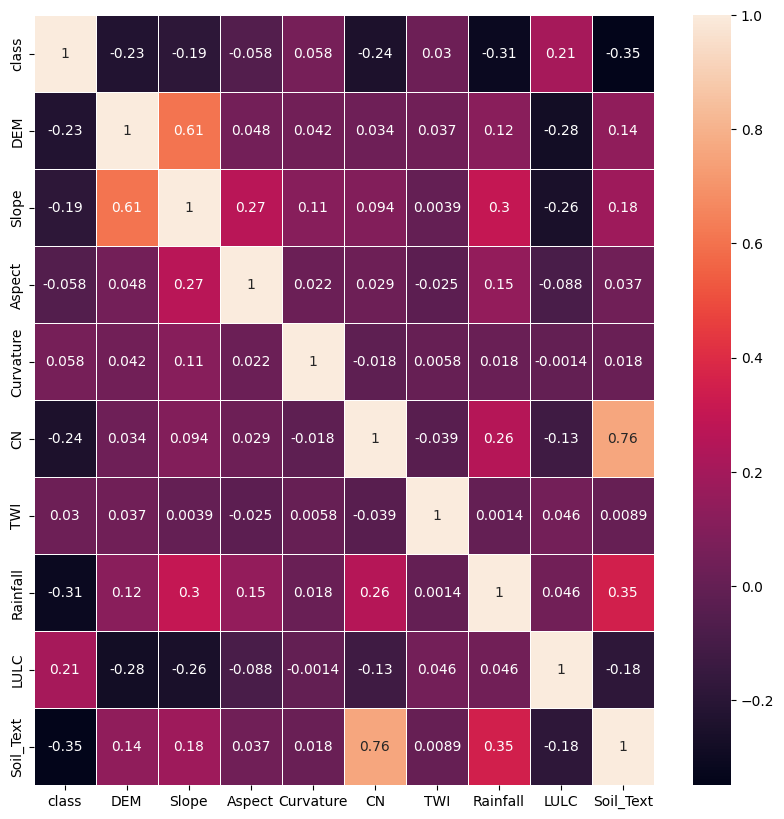

In [9]:
# Correlation between the input features

# corrMatrix = df.corr()
# fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
# #sns.heatmap(df.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
# sns.heatmap(corrMatrix, annot=False, linewidths=.5, ax=ax)
# Select only the numeric columns from the dataframe
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corrMatrix = numeric_df.corr()

# Now you can create the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)


In [10]:
#Define the dependent variable that needs to be predicted (labels)
Y = df["class"].values


In [11]:
#Define the independent variables. 
X = df.drop(labels = ["class",'geometry'], axis=1) 
features_list = list(X.columns)  #List features so we can rank them later.
from sklearn.preprocessing import normalize
# Only needed if the data was not normalized
# X = normalize(X, axis=1)

In [12]:
# the independent variables
X

,DEM,Slope,Aspect,Curvature,CN,TWI,Rainfall,LULC,Soil_Text
0,810,4.124518,56.309933,1.28,71,7.651444,8.634620,30,7
1,798,1.811248,288.434937,-0.64,71,6.457982,9.113000,30,7
2,783,2.429397,45.000000,-1.28,71,8.626627,14.380471,30,7
3,845,0.810231,225.000000,-0.00,71,11.018336,9.009209,30,7
4,803,1.811248,108.434952,-0.64,71,7.151129,11.598495,30,7
...,...,...,...,...,...,...,...,...,...
388,719,0.000000,-9999.000000,-0.00,30,9.554776,10.237988,90,1
389,720,1.811248,161.565048,-0.64,30,6.938687,10.237988,30,1
390,721,0.000000,-9999.000000,-0.00,58,7.469123,10.237988,40,4
391,715,0.000000,-9999.000000,-0.00,58,14.062859,14.165248,90,4


In [13]:
# the dependent variable
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
#Split data into train, validation and test to verify accuracy after fitting the model. 
# Firstly split the data into train_validation and test datasets then split the train_validation dataset into train and validation datasets.
# The training dataset is used to train the model, the validation dataset is used for hyperparamter tuning and the testing dataset is used to test the model.
# It is recommended to test the model with a data that the model hasn't seen in the training process
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.25,shuffle=True, random_state=100)


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,shuffle=True, random_state=100)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [17]:
# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [18]:
# Predict on the validation set
y_val_pred = linear_model.predict(X_val)

In [19]:
# Evaluate the model on the validation set (for regression, often Mean Squared Error is used)
mse = mean_squared_error(y_val, y_val_pred)
print(f'Mean Squared Error on Validation Set: {mse}')

Mean Squared Error on Validation Set: 0.1935878712786131


In [20]:
# Now you can use the trained model to make predictions on the test set
y_test_pred = linear_model.predict(X_test)

In [21]:
y_test_pred

array([ 7.63471396e-01,  6.85242295e-01,  7.31397023e-01,  8.18688802e-01,
        9.28736048e-01,  7.85512039e-01,  7.85696944e-01,  6.19753696e-01,
        1.06235173e+00,  3.18915382e-01,  7.83655914e-01,  9.88202425e-01,
        6.11763865e-01,  7.75299953e-01,  6.30635464e-01,  7.05637970e-01,
        7.91772082e-01,  6.18328298e-01,  7.23136708e-01,  6.42981543e-01,
        6.28722395e-01,  7.29696726e-01,  7.42926529e-01,  7.29299919e-01,
        3.51999695e-01,  3.90346801e-01,  5.35039745e-01,  9.66871921e-01,
        4.90194617e-01,  3.53429339e-01,  7.37642564e-01,  6.47911168e-01,
        5.53214813e-01,  4.39059173e-01,  8.30815535e-01,  8.33411190e-01,
        4.63398176e-01,  4.10547021e-01,  5.69280766e-01,  5.91909160e-01,
        7.49267484e-01,  5.71292082e-01, -4.06896159e+20,  6.20769425e-01,
       -4.06896159e+20,  4.79885953e-01,  4.66990911e-01,  4.73992342e-01,
        8.43763770e-01,  8.53304749e-01,  6.25021100e-01,  2.05809206e-01,
        8.42548353e-01,  

ROC-AUC Score: 0.9568627450980393


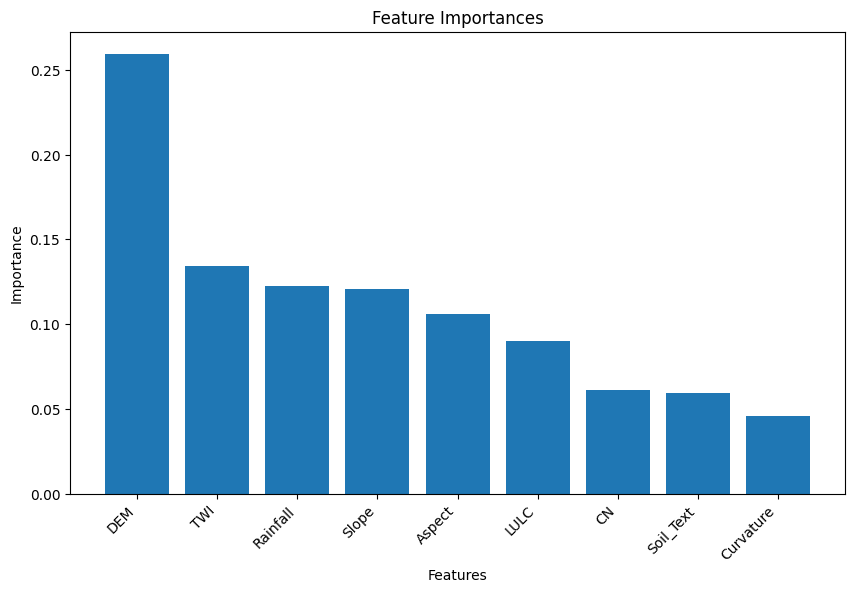

In [22]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'X' is your feature matrix and 'y' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a random forest classifier
model_rf = RandomForestClassifier(random_state=42)

# Train the model
model_rf.fit(X_train, y_train)

# Make predictions on the test set
predictions = model_rf.predict(X_test)

# Get predicted probabilities for positive class
prediction_prob = model_rf.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, prediction_prob)
print(f"ROC-AUC Score: {roc_auc}")

# Get feature importances
feature_importances = model_rf.feature_importances_

# Create a DataFrame with feature names and their importances
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(features_df['Feature'], features_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.show()

ROC-AUC Score: 0.9568627450980393


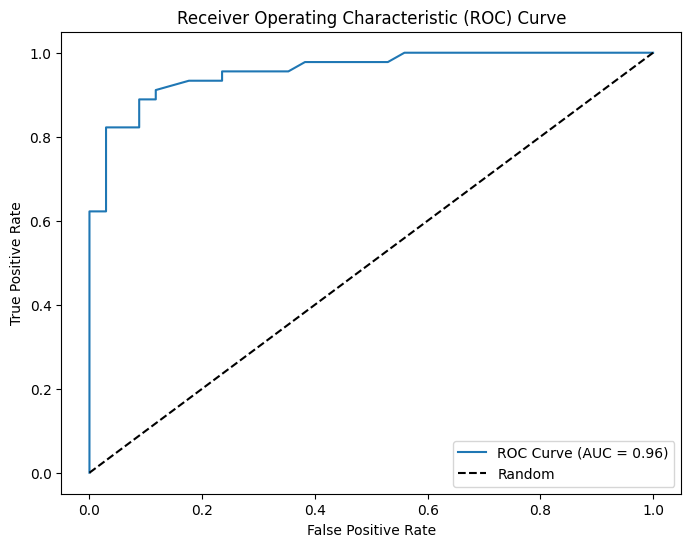

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

# Assuming 'X' is your feature matrix and 'y' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a random forest classifier
model_rf = RandomForestClassifier(random_state=42)

# Train the model
model_rf.fit(X_train, y_train)

# Get predicted probabilities for positive class
prediction_prob = model_rf.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, prediction_prob)
print(f"ROC-AUC Score: {roc_auc}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, prediction_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import classification_report

# Assuming 'X' is your feature matrix, 'y' is your target variable,
# and you have already trained and predicted using a classifier (e.g., RandomForestClassifier)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a random forest classifier
model_rf = RandomForestClassifier(random_state=42)

# Train the model
model_rf.fit(X_train, y_train)

# Get predictions
predictions = model_rf.predict(X_test)

# Print classification report
target_names = ["Not Flooded", "Flooded"]
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

 Not Flooded       0.93      0.74      0.82        34
     Flooded       0.83      0.96      0.89        45

    accuracy                           0.86        79
   macro avg       0.88      0.85      0.85        79
weighted avg       0.87      0.86      0.86        79



In [25]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

# Assuming 'y_test' is the true labels and 'predictions' is your predicted labels
# Discretize the predictions into categories (you may need to adjust the threshold)
threshold = 0.5  # Adjust the threshold based on your problem
predicted_classes = np.where(predictions > threshold, 1, 0)

# Discretize the true labels into categories (you may need to adjust the threshold)
true_classes = np.where(y_test > threshold, 1, 0)

# Calculate Cohen's Kappa Score
kappa_score = cohen_kappa_score(true_classes, predicted_classes)

print(f"Cohen's Kappa Score: {kappa_score}")

Cohen's Kappa Score: 0.7086825343613812


# Amibara


In [26]:
# %pip install pickle
import pickle as pickle


In [27]:
import pickle
import shapely

# Ensure Shapely version is 2.0 or above
assert shapely.__version__ >= '2.0', "Please upgrade Shapely to version 2.0 or above."

# Load the DataFrame from the pickle file
with open('points_data.pkl', 'rb') as fh:
    df = pickle.load(fh)

# Re-save the DataFrame to the pickle file with the latest version of Shapely
df.to_pickle('points_data_updated.pkl')

In [28]:
import pickle
with open('points_data.pkl', "rb") as fh:
  df = pickle.load(fh)


In [29]:
df.head()

,id,label,geometry,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text
0,0,0,POINT (648355.689 1032128.503),810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7
1,1,0,POINT (652338.758 1039898.468),798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7
2,2,0,POINT (654594.349 1045368.461),783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7
3,3,0,POINT (653891.492 1031276.320),845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7
4,4,0,POINT (657859.303 1042542.024),803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7


In [30]:
X_hotspot0= df.drop(labels = ["geometry",'id'], axis=1) 
X_hotspot0.head()

,label,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text
0,0,810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7
1,0,798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7
2,0,783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7
3,0,845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7
4,0,803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7


In [31]:
X_hotspot0.head()

,label,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text
0,0,810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7
1,0,798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7
2,0,783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7
3,0,845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7
4,0,803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7


In [32]:
cols=X.columns
cols

Index(['DEM', 'Slope', 'Aspect', 'Curvature', 'CN', 'TWI', 'Rainfall', 'LULC',
       'Soil_Text'],
      dtype='object')

In [33]:
X_hotspot0=X_hotspot0[cols]
X_hotspot0.head()

,DEM,Slope,Aspect,Curvature,CN,TWI,Rainfall,LULC,Soil_Text
0,810,4.124518,56.309933,1.28,71,7.651444,8.634620,30,7
1,798,1.811248,288.434937,-0.64,71,6.457982,9.113000,30,7
2,783,2.429397,45.000000,-1.28,71,8.626627,14.380471,30,7
3,845,0.810231,225.000000,-0.00,71,11.018336,9.009209,30,7
4,803,1.811248,108.434952,-0.64,71,7.151129,11.598495,30,7


In [34]:
print(X_hotspot0.isnull().sum())


DEM          0
Slope        0
Aspect       0
Curvature    0
CN           0
TWI          0
Rainfall     0
LULC         0
Soil_Text    0
dtype: int64


In [35]:
X_hotspot0 = X_hotspot0.dropna()

In [36]:
df=df.dropna()

In [37]:
prediction = linear_model.predict(X_hotspot0)
prediction

array([ 6.09159370e-01,  4.39059173e-01,  1.63065144e-01,  4.91253258e-01,
        3.11823459e-01,  1.56529826e-01,  4.21466271e-01,  7.91772082e-01,
        2.52240895e-01,  2.81317593e-01,  3.30661251e-01,  6.24826736e-01,
        4.76128363e-01,  2.80433686e-01,  4.43714757e-01,  7.81070983e-01,
        7.03950617e-01,  7.40023779e-01,  2.05809206e-01,  1.13642158e-01,
        1.16284337e-01,  4.63398176e-01,  6.12768250e-01,  7.72891038e-01,
        5.96659080e-01,  4.26114894e-01,  5.18671912e-01,  3.89460641e-01,
        4.06059648e-01,  6.89749178e-01,  5.52908615e-01,  7.19079640e-01,
        4.59193493e-01,  5.44242893e-01,  6.09590896e-01,  7.14008778e-01,
        4.89951372e-01,  5.50820585e-01,  5.39755799e-01,  4.61299023e-01,
        5.17599213e-01,  5.42855402e-01,  9.15026810e-01,  6.28722395e-01,
        5.64878120e-01,  5.33657171e-01,  6.60739561e-01,  7.06579172e-01,
        1.04892913e+00,  8.82815717e-01,  9.15443383e-01,  8.58394003e-01,
        8.06641115e-01,  

In [38]:
ls_hotspot0 = prediction
threshold = 0.5
binary_predictions = np.where(ls_hotspot0 >= threshold, 1, 0)

In [39]:
df['label']=binary_predictions
df.head()

,id,label,geometry,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text
0,0,1,POINT (648355.689 1032128.503),810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7
1,1,0,POINT (652338.758 1039898.468),798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7
2,2,0,POINT (654594.349 1045368.461),783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7
3,3,0,POINT (653891.492 1031276.320),845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7
4,4,0,POINT (657859.303 1042542.024),803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7


In [40]:
binary_predictions= df.drop(labels = ['id'], axis=1) 
binary_predictions.head()

,label,geometry,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text
0,1,POINT (648355.689 1032128.503),810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7
1,0,POINT (652338.758 1039898.468),798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7
2,0,POINT (654594.349 1045368.461),783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7
3,0,POINT (653891.492 1031276.320),845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7
4,0,POINT (657859.303 1042542.024),803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7


# Flood Susceptability Mapping for Linear Regression Model

In [41]:
import geocube
from geocube.api.core import make_geocube
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.plot import show

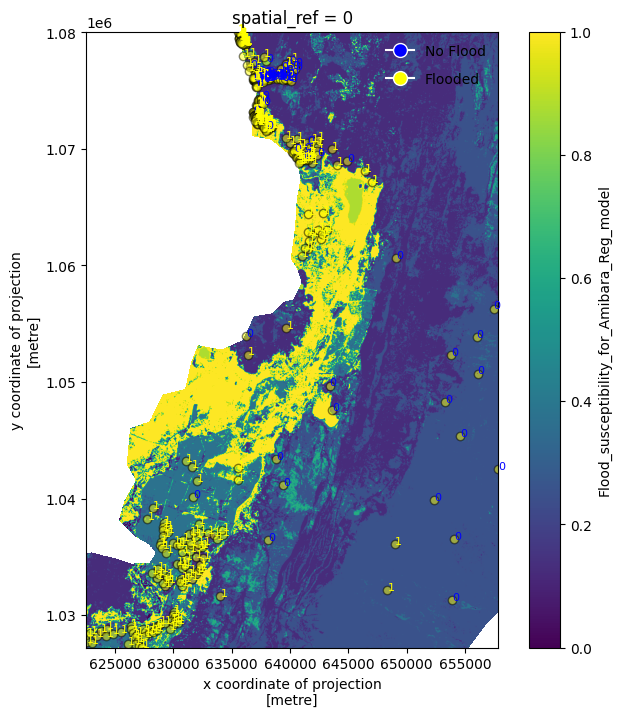

In [42]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from geocube.api.core import make_geocube

# Assuming df is a GeoDataFrame with your vector data

# Create a GeoCube
geo_grid = make_geocube(
    vector_data=df,
    measurements=['label'],
    resolution=(-12.5, 12.5)#image resolution 
)

# Extract the raster data
raster_data = geo_grid.compute()

# Assuming LULC.tif is your LULC raster file with RGB values
lulc_path = 'LULC.tif'
try:
    # Open the raster file using rasterio
    with rasterio.open(lulc_path) as lulc_data:
        # Plot the raster data on a map
        fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the size of the map

        # Assuming the raster_data is a DataArray with the 'label' variable
        im1 = raster_data.label.plot(ax=ax, cmap='viridis', add_colorbar=False)

        # Optionally, overlay your vector data on the map
        df.plot(ax=ax, color='yellow', alpha=0.5, edgecolor='black')

        # Add labels for points
        for idx, row in df.iterrows():
            color = 'yellow' if row['label'] == 1 else 'blue'
            ax.text(row.geometry.x, row.geometry.y, str(row['label']), color=color, fontsize=8)

        # Add legends for flood and no flood with distinct colors
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
                          plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10)]
        legend_labels = {0: 'No Flood', 1: 'Flooded'}
        ax.legend(legend_handles, legend_labels.values(), scatterpoints=1, frameon=False, labelspacing=1, loc='upper right')

        # Show the LULC raster with RGB values
        show(lulc_data, ax=ax)

        # Add default legends for the raster data
        cbar = plt.colorbar(im1, ax=ax, pad=0.04)
        cbar.set_label('Flood_susceptibility_for_Amibara_Reg_model')

        # Show the map
        plt.show()

except rasterio.errors.RasterioIOError:
    print(f"Error: Unable to open raster file at path '{lulc_path}'")

In [43]:
geo_grid.label.rio.to_raster("Flood_susceptibility_for_Amibara_Rmodel.tif")